In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
from scipy import stats
import ipywidgets as widgets
from IPython.display import display

In [2]:
start_date = widgets.DatePicker(
    description='Start Date',
    disabled=False,
    value=date(2025, 1, 30)
)

In [3]:
end_date = widgets.DatePicker(
    description='End Date',
    disabled=False,
    value=date(2025, 1, 31)
)

In [4]:
%run "../Utils.ipynb"

In [5]:
connection, cursor = get_connection()

In [6]:
data = pd.read_sql("SELECT * FROM nft_transactions", con=connection)

In [7]:
chains = data["chain_id"].unique()

chain_wid = widgets.Dropdown(
    options=chains,
    value=chains[0],
    description='Chain Id',
    disabled=False,
)

In [8]:
display(start_date)
display(end_date)
display(chain_wid)

DatePicker(value=datetime.date(2025, 1, 30), description='Start Date', step=1)

DatePicker(value=datetime.date(2025, 1, 31), description='End Date', step=1)

Dropdown(description='Chain Id', options=('ecb10d8c-d51a-4c41-a55c-0124c1d5934b', 'c1f0341d-86d0-4d6a-9b42-9c8…

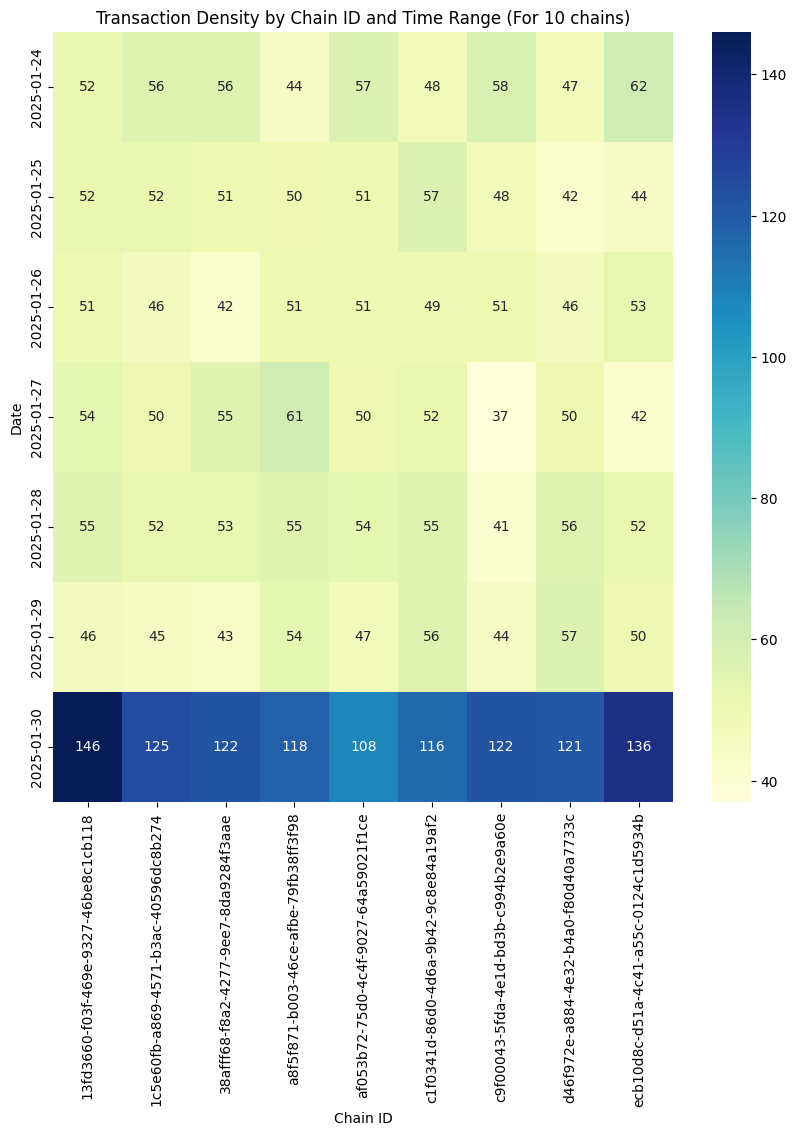

In [9]:
# Display transaction density by `chain_id` and time range using a heatmap.
data["date"] = pd.to_datetime(data['timestamp']).dt.date
chains = data["chain_id"].values[0:10]
filtered = data[data.chain_id.isin(chains)]
pivot_table = filtered.pivot_table(index='date', columns='chain_id', values='transaction_id', aggfunc='nunique')

plt.figure(figsize=(10, 10))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('Transaction Density by Chain ID and Time Range (For 10 chains)')
plt.xlabel('Chain ID')
plt.ylabel('Date')
plt.show()

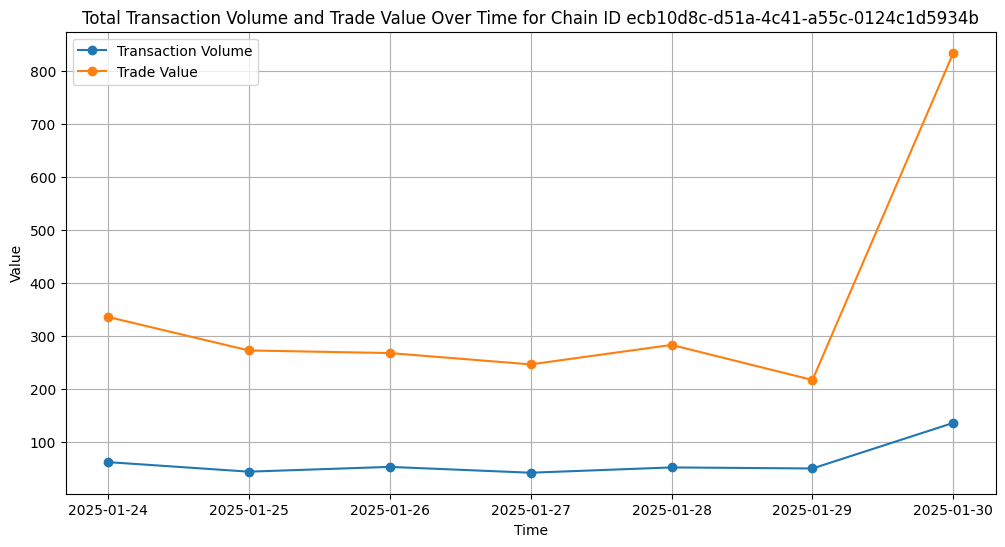

In [10]:
# Plot total transaction volume and trade value over time for a selected chain.
chain = chain_wid.value
filtered = data[data['chain_id'] == chain] 
volume_price = filtered.groupby("date").aggregate({"transaction_id": "nunique", "price": "sum"}).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(volume_price['date'], volume_price['transaction_id'], marker='o', label='Transaction Volume')
plt.plot(volume_price['date'], volume_price['price'], marker='o', label='Trade Value')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Total Transaction Volume and Trade Value Over Time for Chain ID {chain}')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

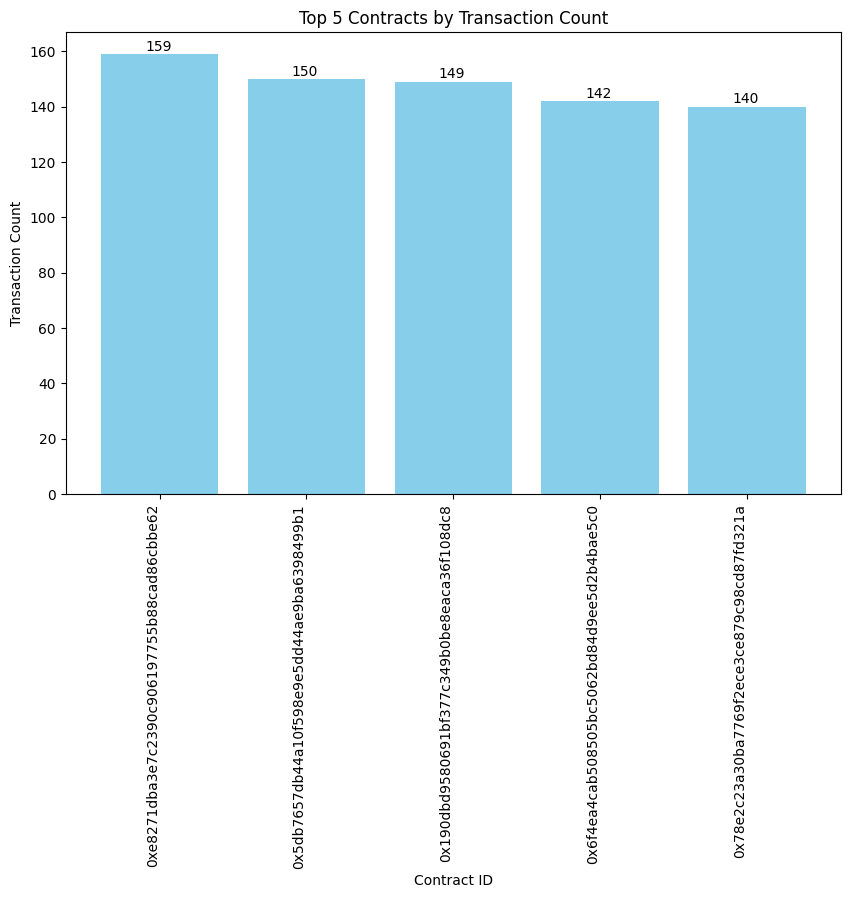

In [11]:
filtered = data[(pd.to_datetime(data["timestamp"]) >= pd.to_datetime(start_date.value)) & (pd.to_datetime(data["timestamp"]) <= pd.to_datetime(end_date.value))]
contracts = filtered.groupby("contract_address")['transaction_id'].count().nlargest(5).reset_index()

plt.figure(figsize=(10, 6))
bars = plt.bar(contracts['contract_address'], contracts['transaction_id'], color='skyblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2 - 0.1, yval + 0.2, int(yval), va='bottom') 

plt.xticks(rotation=90, ha='right')
plt.xlabel('Contract ID')
plt.ylabel('Transaction Count')
plt.title('Top 5 Contracts by Transaction Count')
plt.show()

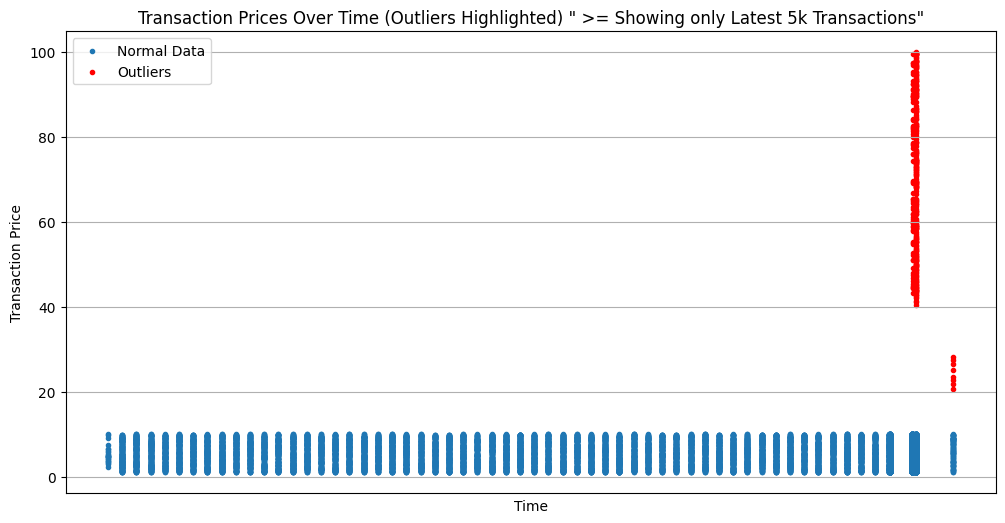

In [12]:
data['z_score'] = stats.zscore(data['price'])
data['is_outlier'] = data['z_score'].abs() > 2
data['trunc_date'] = pd.to_datetime(data["timestamp"]).apply(lambda x: x.replace(second=0))
filtered = data.sort_values(by='timestamp', ascending=False).head(20000)

plt.figure(figsize=(12, 6))
normal_data = filtered[~filtered['is_outlier']]
outlier_data = filtered[filtered['is_outlier']]

plt.scatter(normal_data['trunc_date'], normal_data['price'], marker='.', label='Normal Data')
plt.scatter(outlier_data['trunc_date'], outlier_data['price'], marker='.', color='red', label='Outliers')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Transaction Price')
plt.title('Transaction Prices Over Time (Outliers Highlighted) " >= Showing only Latest 5k Transactions"')
plt.xticks([])
plt.legend()
plt.grid(True)

plt.show()

In [13]:
connection.close()